In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

import dash
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd
import plotly.graph_objs as go
from dash.dependencies import Input, Output
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [2]:
app = dash.Dash()
server = app.server

scaler=MinMaxScaler(feature_range=(0,1))

df = pd.read_csv("BeloitWWTP.csv")
df

,Date,Influent_Flow,Influent_CBOD,Influent_TSS,Influent_TP,Influent_NH3,Aeration_MLDO_3,Aeration_MLDO_4,Aeration_MLDO_5,Aeration_MLTSS_3,...,RAS_Feed_AB_4,RAS_Feed_AB_5,WAS_Flow_Total,Effluent_Flow(MGD),Effluent_CBOD,Effluent_TSS,Effluent_NH3,Effluent_TP,Effluent_Temp,Electric_PlantSubStation(KWH)
0,7/1/2018,6.23,548.95,182.0,5.2,16.20,3.80,3.01,3.86,NaN,...,1.90,1.65,170325.0,6.48,NaN,2.50,0.08,0.22,72.24,19218.24
1,7/2/2018,6.05,548.95,238.0,5.0,25.51,4.14,3.11,4.63,3390.0,...,2.01,1.74,165382.0,6.30,NaN,3.80,0.08,0.19,71.38,17677.80
2,7/3/2018,5.82,548.95,172.0,1.0,19.70,3.23,2.49,3.46,3390.0,...,2.09,1.81,154804.0,5.83,NaN,4.30,0.08,0.23,71.29,19474.56
3,7/4/2018,5.57,450.00,204.0,6.5,25.51,3.50,2.58,3.41,3430.0,...,1.76,1.53,156037.0,5.35,4.2,4.50,0.08,0.27,72.23,19233.36
4,7/5/2018,5.47,446.00,192.0,7.2,22.90,2.66,2.53,3.12,3430.0,...,1.77,1.53,149832.0,5.61,5.2,4.50,0.10,0.37,72.45,18957.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,3/12/2021,4.29,573.75,144.0,11.8,31.40,3.21,3.31,2.51,5560.0,...,0.90,0.79,106191.0,4.30,2.4,3.66,0.11,0.21,62.12,6622.20
986,03/13/2021,4.04,573.75,176.0,11.8,31.40,2.55,2.93,2.32,5560.0,...,0.91,0.79,114932.0,4.08,2.4,2.00,0.11,0.21,61.82,6622.20
987,03/14/2021,4.17,573.75,180.0,11.8,31.40,2.70,3.08,2.44,4820.0,...,0.87,0.76,109710.0,3.93,2.4,2.60,0.11,0.21,61.14,6622.20
988,03/15/2021,4.10,573.75,276.0,11.8,31.40,3.10,3.56,2.47,4820.0,...,0.92,0.80,101790.0,4.19,2.4,2.20,0.11,0.21,59.02,6622.20


In [3]:
df["Date"]=pd.to_datetime(df.Date,format="%m/%d/%Y")
df.index=df['Date']

data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Influent_Flow'])

In [4]:
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Influent_Flow"][i]=data["Influent_Flow"][i]

new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

dataset=new_dataset.values

train_data=dataset[0:800,:]
valid_data=dataset[800:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [5]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

2023-04-24 12:35:36.024930: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


740/740 - 11s - loss: 0.0056 - 11s/epoch - 15ms/step


In [6]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_Influent_Flow=lstm_model.predict(X_test)
predicted_Influent_Flow=scaler.inverse_transform(predicted_Influent_Flow)

6/6 [==============================] - 1s 10ms/step


In [7]:
lstm_model.save("saved_model.h5")

/var/folders/wx/jd5wkv_d6f3_lzzhks8pj4hh0000gn/T/ipykernel_16455/647317816.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_Influent_Flow


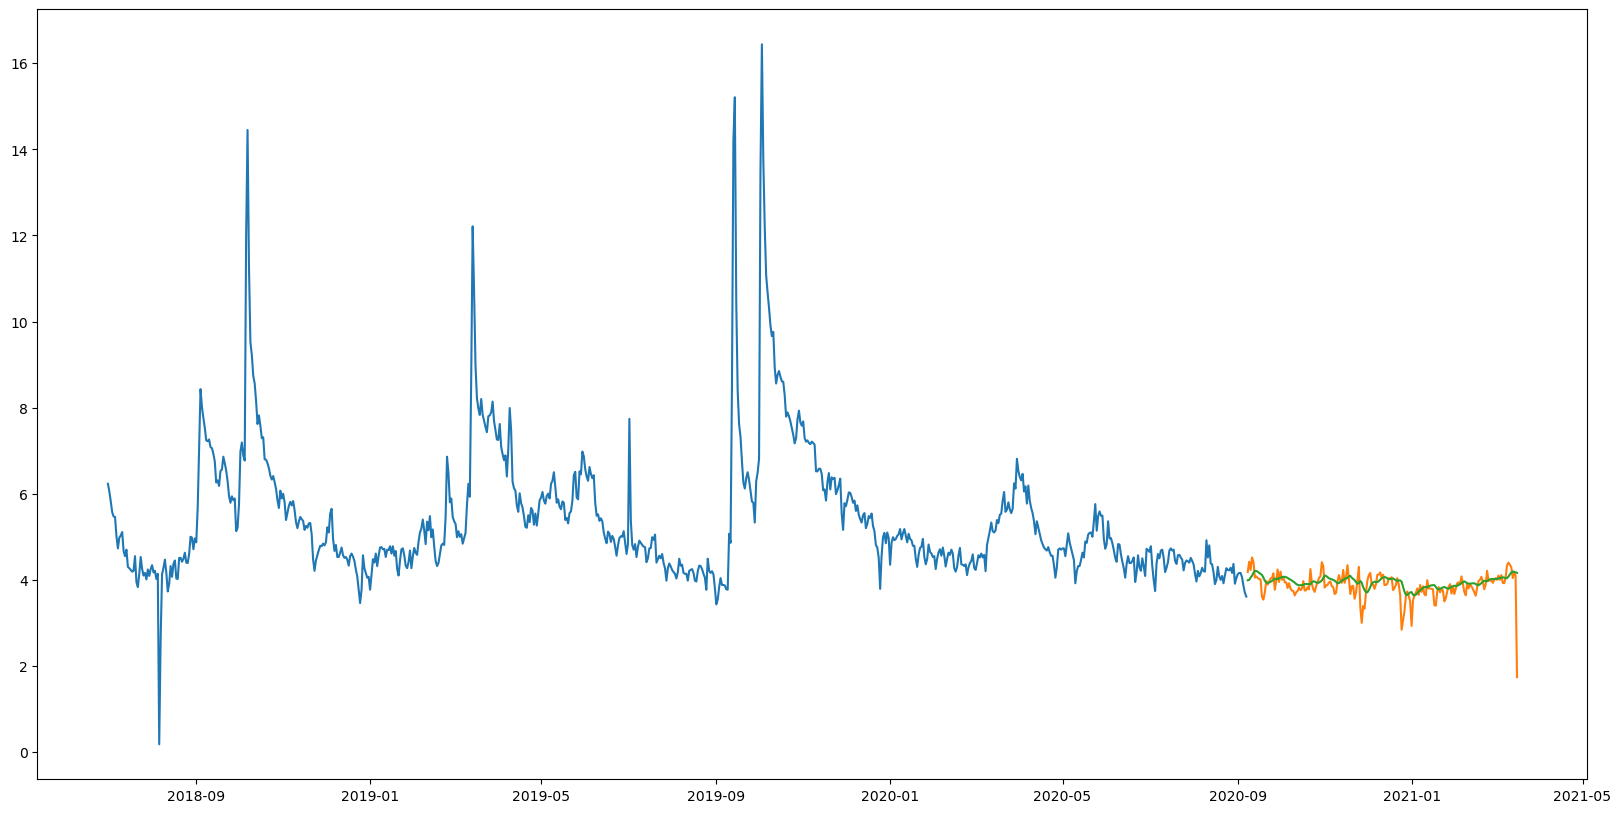

In [10]:
train_data=new_dataset[:800]
valid_data=new_dataset[800:]
valid_data['Predictions']=predicted_Influent_Flow
plt.plot(train_data["Influent_Flow"])
plt.plot(valid_data[['Influent_Flow',"Predictions"]])

In [11]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd
import plotly.graph_objs as go
from dash.dependencies import Input, Output
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [ ]:
app.layout = html.Div([
   
    html.H1("Influent Dashboard", style={"textAlign": "center"}),
   
    dcc.Tabs(id="tabs", children=[
       
        dcc.Tab(label='Beloit WWTP Data',children=[
            html.Div([
                html.H2("Actual Influent Flow",style={"textAlign": "center"}),
                dcc.Graph(
                    id="Actual Data",
                    figure={
                        "data":[
                            go.Scatter(
                                x=train.index,
                                y=valid["Influent_Flow"],
                                mode='markers'
                            )
                        ],
                        "layout":go.Layout(
                            title='scatter plot',
                            xaxis={'title':'Date'},
                            yaxis={'title':'Influent Flow'}
                        )
                    }
                ),
                html.H2("LSTM Predicted Influent Flow",style={"textAlign": "center"}),
                dcc.Graph(
                    id="Predicted Data",
                    figure={
                        "data":[
                            go.Scatter(
                                x=valid.index,
                                y=valid["Predictions"],
                                mode='markers'
                            )
                        ],
                        "layout":go.Layout(
                            title='scatter plot',
                            xaxis={'title':'Date'},
                            yaxis={'title':'Influent Flow'}
                        )
                    }
                )                
            ])                
        ]),
        dcc.Tab(label='Wastewater Treatment Data', children=[
            html.Div([
                html.H1("Influent Flow vs Effluent Flow", 
                        style={'textAlign': 'center'}),
              
                dcc.Dropdown(id='my-dropdown',
                             options=[{'label': 'Influent Flow', 'value': 'Influent_Flow'},
                                      {'label': 'Influent CBOD','value': 'Influent_CBOD'}, 
                                      {'label': 'Influent TSS', 'value': 'Influent_TSS'}, 
                                      {'label': 'Influent TP','value': 'Influent_TP'}], 
                             multi=True,value=['Influent_Flow'],
                             style={"display": "block", "margin-left": "auto", 
                                    "margin-right": "auto", "width": "60%"}),
                dcc.Graph(id='InfluentEffluent'),
                html.H1("Influent Flow", style={'textAlign': 'center'}),
         
                dcc.Dropdown(id='my-dropdown2',
                             options=[{'label': 'Tesla', 'value': 'TSLA'},
                                      {'label': 'Apple','value': 'AAPL'}, 
                                      {'label': 'Facebook', 'value': 'FB'},
                                      {'label': 'Microsoft','value': 'MSFT'}], 
                             multi=True,value=['FB'],
                             style={"display": "block", "margin-left": "auto", 
                                    "margin-right": "auto", "width": "60%"}),
                dcc.Graph(id='volume')
            ], className="container"),
        ])
    ])
])
@app.callback(Output('highlow', 'figure'),
              [Input('my-dropdown', 'value')])
def update_graph(selected_dropdown):
    dropdown = {"TSLA": "Tesla","AAPL": "Apple","FB": "Facebook","MSFT": "Microsoft",}
    trace1 = []
    trace2 = []
    for stock in selected_dropdown:
        trace1.append(
          go.Scatter(x=df[df["Stock"] == stock]["Date"],
                     y=df[df["Stock"] == stock]["High"],
                     mode='lines', opacity=0.7, 
                     name=f'High {dropdown[stock]}',textposition='bottom center'))
        trace2.append(
          go.Scatter(x=df[df["Stock"] == stock]["Date"],
                     y=df[df["Stock"] == stock]["Low"],
                     mode='lines', opacity=0.6,
                     name=f'Low {dropdown[stock]}',textposition='bottom center'))
    traces = [trace1, trace2]
    data = [val for sublist in traces for val in sublist]
    figure = {'data': data,
              'layout': go.Layout(colorway=["#5E0DAC", '#FF4F00', '#375CB1', 
                                            '#FF7400', '#FFF400', '#FF0056'],
            height=600,
            title=f"High and Low Prices for {', '.join(str(dropdown[i]) for i in selected_dropdown)} Over Time",
            xaxis={"title":"Date",
                   'rangeselector': {'buttons': list([{'count': 1, 'label': '1M', 
                                                       'step': 'month', 
                                                       'stepmode': 'backward'},
                                                      {'count': 6, 'label': '6M', 
                                                       'step': 'month', 
                                                       'stepmode': 'backward'},
                                                      {'step': 'all'}])},
                   'rangeslider': {'visible': True}, 'type': 'date'},
             yaxis={"title":"Price (USD)"})}
    return figure
@app.callback(Output('volume', 'figure'),
              [Input('my-dropdown2', 'value')])
def update_graph(selected_dropdown_value):
    dropdown = {"TSLA": "Tesla","AAPL": "Apple","FB": "Facebook","MSFT": "Microsoft",}
    trace1 = []
    for stock in selected_dropdown_value:
        trace1.append(
          go.Scatter(x=df[df["Stock"] == stock]["Date"],
                     y=df[df["Stock"] == stock]["Volume"],
                     mode='lines', opacity=0.7,
                     name=f'Volume {dropdown[stock]}', textposition='bottom center'))
    traces = [trace1]
    data = [val for sublist in traces for val in sublist]
    figure = {'data': data, 
              'layout': go.Layout(colorway=["#5E0DAC", '#FF4F00', '#375CB1', 
                                            '#FF7400', '#FFF400', '#FF0056'],
            height=600,
            title=f"Market Volume for {', '.join(str(dropdown[i]) for i in selected_dropdown_value)} Over Time",
            xaxis={"title":"Date",
                   'rangeselector': {'buttons': list([{'count': 1, 'label': '1M', 
                                                       'step': 'month', 
                                                       'stepmode': 'backward'},
                                                      {'count': 6, 'label': '6M',
                                                       'step': 'month', 
                                                       'stepmode': 'backward'},
                                                      {'step': 'all'}])},
                   'rangeslider': {'visible': True}, 'type': 'date'},
             yaxis={"title":"Transactions Volume"})}
    return figure
if __name__=='__main__':
    app.run_server(debug=True)